In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from langid.langid import LanguageIdentifier, model
from IPython.display import clear_output
from time import sleep
from transformers import pipeline

/home/bszafranski/projects/private/rotten_tomatoes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("rotten_tomatoes")

In [3]:
ds.save_to_disk("dupa")

Saving the dataset (1/1 shards): 100%|██████████| 1066/1066 [00:00<00:00, 196239.82 examples/s]


# Data validation (using all splits)

In [7]:
DatasetDict.load_from_disk("dupa")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [3]:
set(ds['train']['label'])

{0, 1}

In [ ]:
print("distilbert says negative, dataset says positive")
print("some sentences are definitely 'one fly in the oinment' type of situation, other are hard to assess, there are no blatant mistakes visible")
diffs_in_labels[diffs_in_labels["distilbert_label"]==0].sort_values(by='distilbert_score', ascending=False).head(10)["text"].values

distilbert says negative, dataset says positive
some sentences are definitely 'one fly in the oinment' type of situation, other are hard to assess, there are no blatant mistakes visible


array(["the paradiso's rusted-out ruin and ultimate collapse during the film's final ( restored ) third\x85emotionally belittle a cinema classic . sometimes shorter is better .",
       'baran is shockingly devoid of your typical majid majidi shoe-loving , crippled children .',
       "' . . . the film's considered approach to its subject matter is too calm and thoughtful for agitprop , and the thinness of its characterizations makes it a failure as straight drama . '",
       'solondz is so intent on hammering home his message that he forgets to make it entertaining .',
       'just another fish-out-of-water story that barely stays afloat .',
       "it's a strange film , one that was hard for me to warm up to .",
       'a decided lack of spontaneity in its execution and a dearth of real poignancy in its epiphanies .',
       "the film doesn't sustain its initial promise with a jarring , new-agey tone creeping into the second half",
       "for a film that's being advertised as a com

In [4]:
ds.set_format(type="pandas")

In [5]:
train_df = ds["train"][:]
validation_df = ds["validation"][:]
test_df = ds["test"][:]

In [6]:
names = ["train set", "validation set", "test set"]
dfs = [train_df, validation_df, test_df]

In [7]:
for name, df in zip(names, dfs):
    print(f"{name} size:", len(df))
    print(f"classes in {name}:", df['label'].unique())
    print(f"Missing values in {name}:", df.isna().sum().to_dict())
    print(f"Col types of {name}:", df.dtypes.to_dict())
    print(f"Make sure all text fields are indeed string for {name}:", df["text"].apply(type).unique())
    print("\n")

train set size: 8530
classes in train set: [1 0]
Missing values in train set: {'text': 0, 'label': 0}
Col types of train set: {'text': dtype('O'), 'label': dtype('int64')}
Make sure all text fields are indeed string for train set: [<class 'str'>]


validation set size: 1066
classes in validation set: [1 0]
Missing values in validation set: {'text': 0, 'label': 0}
Col types of validation set: {'text': dtype('O'), 'label': dtype('int64')}
Make sure all text fields are indeed string for validation set: [<class 'str'>]


test set size: 1066
classes in test set: [1 0]
Missing values in test set: {'text': 0, 'label': 0}
Col types of test set: {'text': dtype('O'), 'label': dtype('int64')}
Make sure all text fields are indeed string for test set: [<class 'str'>]




# Data exploration (using train set)

### y

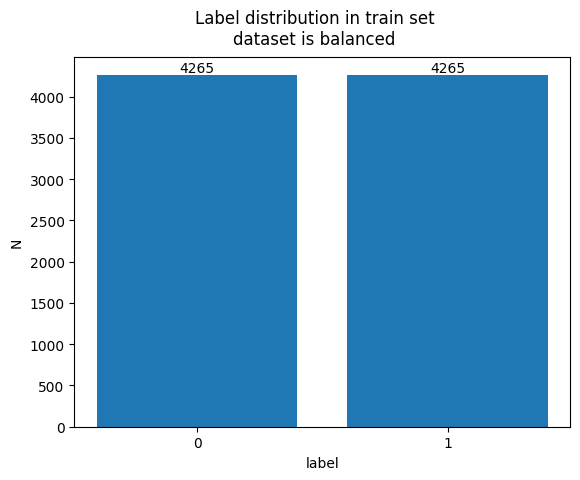

In [8]:
fig, ax = plt.subplots()
ax.bar(x=train_df["label"].value_counts().index, height=train_df["label"].value_counts().values)
ax.bar_label(ax.containers[0])
ax.set_xticks([0,1])
ax.set_xlabel("label")
ax.set_ylabel("N")
_ = fig.suptitle("Label distribution in train set\ndataset is balanced")

### x

In [9]:
train_df["len"] = train_df["text"].apply(len)

,count,mean,std,min,1%,25%,50%,75%,99%,max
len,8530.0,113.97163,51.052231,4.0,21.0,76.0,111.0,149.0,241.0,267.0


Text(0.5, 0.98, 'Review length distribution')

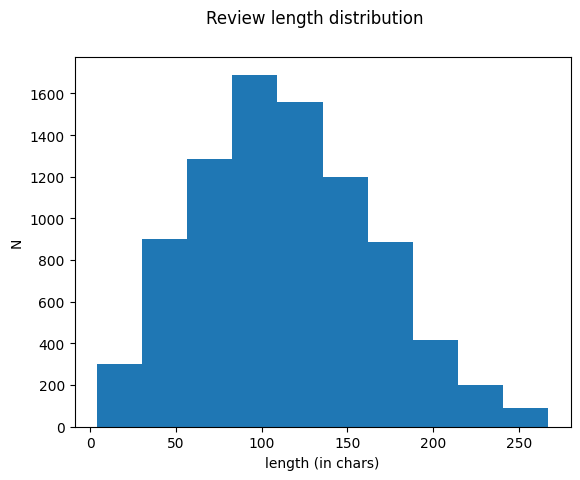

In [10]:
display(train_df["len"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).to_frame().T)
fig, ax = plt.subplots()
_ = ax.hist(train_df["len"])
ax.set_xlabel("length (in chars)")
ax.set_ylabel("N")
fig.suptitle("Review length distribution")

In [11]:
# sanity check on shortest reviews
train_df.sort_values(by="len").head(10)

,text,label,len
6851,eh .,0,4
4852,obvious,0,7
5483,horrible,0,8
2517,touché !,1,8
6688,shallow .,0,9
7592,[a] mess .,0,10
3971,fantastic !,1,11
4658,execrable .,0,11
3705,a fun ride .,1,12
2586,refreshing .,1,12


In [12]:
# sanity check on longest reviews
print(("\n"+"--"*30+"\n").join(train_df.sort_values(by="len").tail(10)["text"].values))

even if the enticing prospect of a lot of nubile young actors in a film about campus depravity didn't fade amid the deliberate , tiresome ugliness , it would be rendered tedious by avary's failure to construct a story with even a trace of dramatic interest .
------------------------------------------------------------
a fine documentary can be distinguished from a mediocre one by the better film's ability to make its subject interesting to those who aren't part of its supposed target audience . judging by those standards , 'scratch' is a pretty decent little documentary .
------------------------------------------------------------
sitting in the third row of the imax cinema at sydney's darling harbour , but i sometimes felt as though i was in the tiny two seater plane that carried the giant camera around australia , sweeping and gliding , banking and hovering over some of the most not
------------------------------------------------------------
notwithstanding my problem with the movi

In [44]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
train_df["lang"] = train_df["text"].apply(identifier.classify)
train_df["lang_id"] = train_df["lang"].apply(lambda x: x[0])
train_df["lang_proba"] = train_df["lang"].apply(lambda x: x[1])
train_df["lang_id"].value_counts()

In [ ]:
print("manually check correctness")
train_df["is_eng"] = 1
for idx in train_df[train_df["lang_id"]!="en"].index:
    sleep(1)
    print(train_df.loc[idx, "text"])
    verdict = int(input("english?"))
    train_df.loc[idx, "is_eng"] = verdict
    sleep(1)
    clear_output()

In [111]:
print("quickly glimpse through 30 examples classified as english that the model was least sure about to check for false positives")
print("it looks alright")
train_df[train_df['lang_id']=="en"].sort_values(by='lang_proba').head(30)

quickly glimpse through 30 examples classified as english that the model was least sure about to check for false positives
it looks alright


,text,label,len,lang,lang_id,lang_proba,is_eng
4852,obvious,0,7,"(en, 0.16946150595865334)",en,0.169462,1
921,a modest masterpiece .,1,22,"(en, 0.16946150595865334)",en,0.169462,1
6851,eh .,0,4,"(en, 0.16946150595865334)",en,0.169462,1
6588,feeble comedy .,0,15,"(en, 0.16946150595865334)",en,0.169462,1
2730,morvern rocks .,1,15,"(en, 0.16946150595865334)",en,0.169462,1
26,spiderman rocks,1,15,"(en, 0.16946150595865334)",en,0.169462,1
1574,an absurdist spider web .,1,25,"(en, 0.16946150595865334)",en,0.169462,1
5483,horrible,0,8,"(en, 0.16946150595865334)",en,0.169462,1
485,never [sinks] into exploitation .,1,33,"(en, 0.283319292683818)",en,0.283319,1
83,an imaginative comedy/thriller .,1,32,"(en, 0.3177363858422182)",en,0.317736,1


In [91]:
print(f'we have identified {sum(train_df["is_eng"]==0)} [{round((1-train_df["is_eng"].mean())*100, 2)}%] non-english examples')

we have identified 47 [0.55%] non-english examples


In [102]:
print(f'out of them, {(train_df[train_df["is_eng"]==0]["lang_proba"].round(4)==1).sum()} have probability of being non-engligh of (almost) 1')
# TODO: add transformer that checks the language and translates to english is conditions are not met

out of them, 44 have probability of being non-engligh of (almost) 1


In [109]:
print("there are almost no uppercase chars - only 3 examples, all non english")
train_df[train_df["text"].apply(lambda x: sum([char.isupper() for char in x])) > 0]

there are almost none uppercase chars - only 3 examples, all non english


,text,label,len,lang,lang_id,lang_proba,is_eng
3297,o Último suspeito ganha força ao também funcio...,1,97,"(pt, 1.0)",pt,1.0,0
3760,os problemas têm início a partir do momento em...,1,159,"(pt, 1.0)",pt,1.0,0
4173,"É uma pena que , mais tarde , o próprio filme ...",1,131,"(pt, 0.9999999999997031)",pt,1.0,0


#### Looking for errors/mislabeled examples

In [ ]:
# TODO: continue with that

In [17]:
sentiment_pipeline = pipeline("sentiment-analysis", "distilbert-base-uncased-finetuned-sst-2-english")

In [18]:
scores = sentiment_pipeline(train_df["text"].tolist())

In [23]:
train_df["distilbert_label"] = [i["label"] for i in scores]
train_df["distilbert_score"] = [i["score"] for i in scores]

In [26]:
train_df['distilbert_label'] = train_df['distilbert_label'].map({"POSITIVE": 1, "NEGATIVE": 0})

In [29]:
diffs_in_labels = train_df[train_df['label']!=train_df['distilbert_label']].copy()

In [37]:
print("distilbert says negative, dataset says positive")
print("some sentences are definitely 'one fly in the oinment' type of situation, other are hard to assess, there are no blatant mistakes visible")
diffs_in_labels[diffs_in_labels["distilbert_label"]==0].sort_values(by='distilbert_score', ascending=False).head(10)["text"].values

distilbert says negative, dataset says positive
some sentences are definitely 'one fly in the oinment' type of situation, other are hard to assess, there are no blatant mistakes visible


array(["the paradiso's rusted-out ruin and ultimate collapse during the film's final ( restored ) third\x85emotionally belittle a cinema classic . sometimes shorter is better .",
       'baran is shockingly devoid of your typical majid majidi shoe-loving , crippled children .',
       "' . . . the film's considered approach to its subject matter is too calm and thoughtful for agitprop , and the thinness of its characterizations makes it a failure as straight drama . '",
       'solondz is so intent on hammering home his message that he forgets to make it entertaining .',
       'just another fish-out-of-water story that barely stays afloat .',
       "it's a strange film , one that was hard for me to warm up to .",
       'a decided lack of spontaneity in its execution and a dearth of real poignancy in its epiphanies .',
       "the film doesn't sustain its initial promise with a jarring , new-agey tone creeping into the second half",
       "for a film that's being advertised as a com

In [40]:
print("Again, we can infer that some of these are are only strong points in otherwise negative review, some require some sarcasm detection abilities (graffiti bridge). There are no visible mistakes on dataset's part")
diffs_in_labels[diffs_in_labels["distilbert_label"]==1].sort_values(by='distilbert_score', ascending=False).head(10)["text"].values

Again, we can infer that some of these are are only strong points in otherwise negative review, some require some sarcasm detection abilities (graffiti bridge). There are no visible mistakes on dataset's part


array(['[at least] moore is a real charmer .',
       "it's the funniest american comedy since graffiti bridge .",
       "at least it's a fairly impressive debut from the director , charles stone iii .",
       "even if you feel like you've seen this movie a thousand times before , it is kind of enjoyable thanks mainly to belushi's easy-going likableness .",
       "it's refreshing that someone understands the need for the bad boy ; diesel , with his brawny frame and cool , composed delivery , fits the bill perfectly .",
       "on the bright side , it contains jesse ventura's best work since the xfl .",
       'the filmmakers know how to please the eye , but it is not always the prettiest pictures that tell the best story .',
       'a quaint , romanticized rendering .',
       'the cast is uniformly excellent . . . but the film itself is merely mildly charming .',
       'the film takes the materials of human tragedy and dresses them in lovely costumes , southern california location

Two cells above indicate that even though the task of sentiment analysis seems pretty straightforward, this dataset is non trivial task as there are sentences that 

    - without context, are challenging even for a human

    - require additional knowledge of cinema

    - require sense of humour/sarcasm

    - require sensing that some sentences, even though they seem to be positive/negative are just 
    reviewer's trials of finding positive/negative aspects of otherwise bad/good movies.
    
    - contain advanced metaphors ("spy kids 2 looks as if it were made by a highly gifted 12-year-old instead of a grown man")